# In this example, we show you how to run an MCMC using the emulator derived in the previous assignment.

### For this you need to install emcee: https://emcee.readthedocs.io/en/stable/user/install/

In [10]:
import matplotlib.pyplot as plt
import random
import numpy as np
from numpy.linalg import inv
from cosmopower_NN import cosmopower_NN
import tensorflow as tf

## Preparation: load the emulator with its rescaling, one reference model we have not trained on, the corresponding parameters, and the covariance matrix.

In [11]:
reference_index  = [8000]

parameters = np.load('data_4_assignment2/parameters.npz')
reference_params = {}
for name in parameters.keys():
    reference_params[name]=list(np.array(parameters[name])[reference_index])


models = np.load('data_4_assignment2/models.npy')   
reference_model = np.load('data_4_assignment2/models.npy')[reference_index][0]


cov=np.load('data_4_assignment1/covariance.npy')
cov_inv = inv(cov)

cp_nn_model = cosmopower_NN(restore=True, restore_filename='data_4_assignment3/emulator_final')


train_sample = np.arange(0,7000)
train_features = np.load('data_4_assignment2/models.npy')[train_sample]
minimum=np.min(train_features,axis=0)
maximum=np.max(train_features-minimum,axis=0)

#### Next we will show you a example MCMC. Try to run it.

In [12]:
import emcee
import multiprocess as mp
import os 

total_steps = 2000 # total  number of steps each walker is doing
burning_steps = 1000 # how many buring steps you want to remove
nwalkers = 50 # Number of walkers that probe the parameter space

num_threads = 10 # number of cpu cores to use

#which paramters we want to vary
parameters = np.load('data_4_assignment2/parameters.npz')
param_names_varying = ['omega_m', 'As'] # alternatively you can also just use parameters.files
ndim = len(param_names_varying)


## a function that distributed start postions inside the trained parameters
def start_position_lh_and_step_size(seed):
    random.seed(seed)
    p0 = []
    for i in range(nwalkers):
        random_starts = []
        
        for name in param_names_varying:
            lower_edge = np.min(parameters[name])
            upper_edge = np.max(parameters[name])
            if(lower_edge<0):
                lower_edge = lower_edge * 0.99
            else:
                lower_edge = lower_edge * 1.01
            if(upper_edge>0):
                upper_edge = upper_edge * 0.99
            else:
                upper_edge = upper_edge * 1.01     
                
            random_starts.append(random.uniform(lower_edge,upper_edge))

        p0.append(random_starts)
        
    return np.array(p0)

## function that computes our priors. Here we only allow the walker to be inside the training range. You can also define Gaussian priors. 
def cal_logprior(para_dict):

    lnprior = 0
    #cosmological priors
    for name in param_names_varying:
        if(para_dict[name]>np.max(parameters[name])):
            lnprior = -np.inf
        if(para_dict[name]<np.min(parameters[name])):
            lnprior = -np.inf
    
    return lnprior

## Function that computes the likelihood
def calc_likelihood(para):
    
    params = {'omega_b':reference_params['omega_b'],'w':reference_params['w']}
    for i in range(len(param_names_varying)):
        params[param_names_varying[i]] = [para[i]]

    # print(params)

    pred_vector = cp_nn_model.predictions_np(params)[0]
    pred_vector = pred_vector*maximum+minimum 
    
    # print(pred_vector.shape,reference_model.shape,cov_inv.shape)
    
    delta = pred_vector - reference_model
    likelihood = -0.5*np.matmul(delta,np.matmul(cov_inv,delta))

    lnprior = cal_logprior(para_dict=params)

    return likelihood+lnprior



print(emcee.__version__)
p0 = start_position_lh_and_step_size(0)


3.1.4


In [6]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, calc_likelihood)
sampler.run_mcmc(p0, total_steps, progress=True)

samples_emcee = sampler.get_chain(discard=burning_steps,flat=True)
np.save('data_4_assignment3/outputs_MCMC/MCMC_test_emcee',samples_emcee)
log_prob_samples = sampler.get_log_prob(discard=burning_steps, flat=True)
np.save('data_4_assignment3/outputs_MCMC/logp_test_emcee',log_prob_samples)


100%|██████████| 2000/2000 [09:31<00:00,  3.50it/s]


Removed no burn in


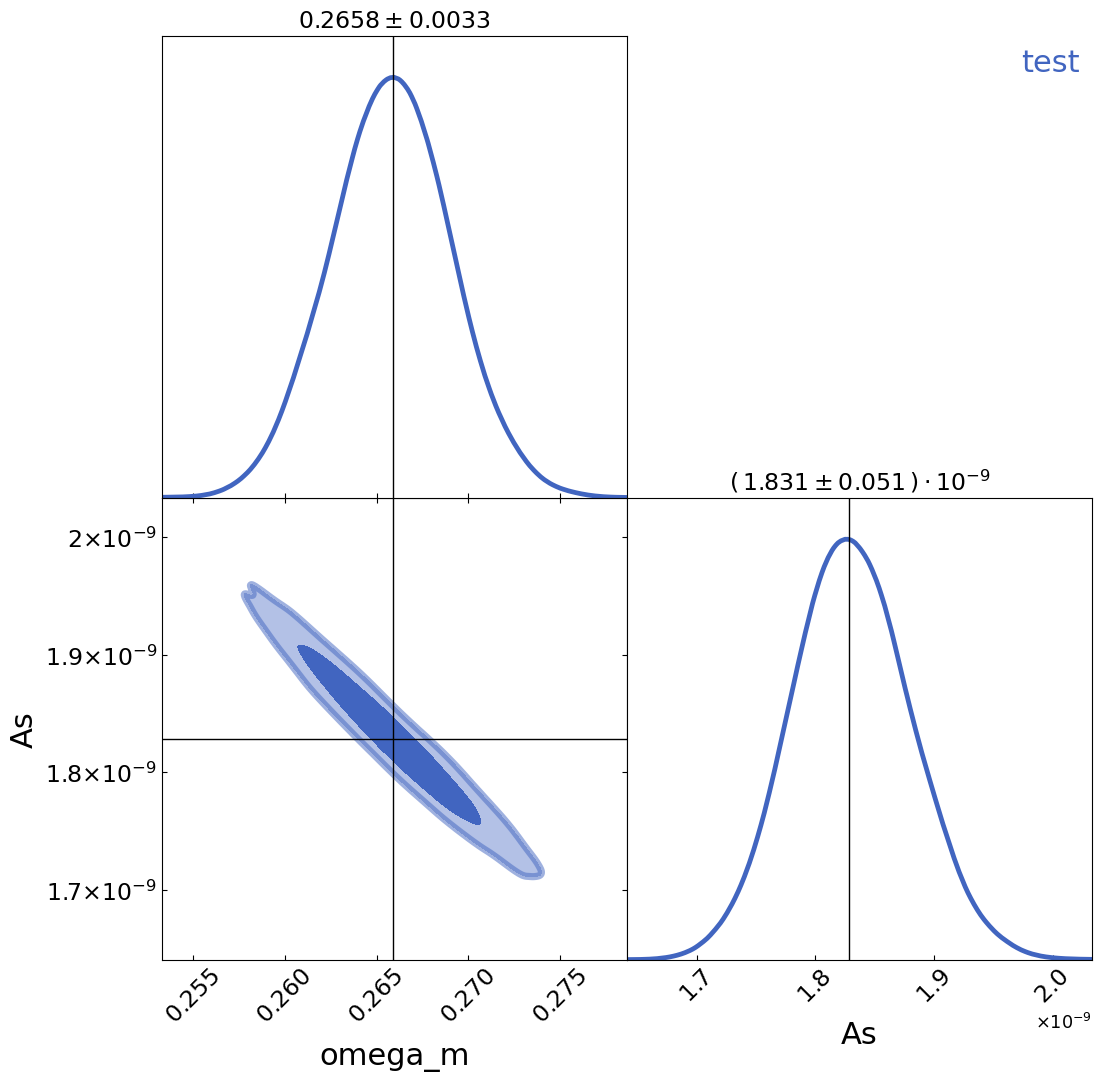

In [9]:
from getdist import plots, MCSamples, parampriors
import getdist


para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])[[0,2]]
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']

parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])


samples_getdist = MCSamples(samples=samples_emcee,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})


colors = ['lightcoral', 'royalblue', 'orange']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()
# priors.names = para_names
# priors.lower = para_priors_low
# priors.upper = para_priors_up

g.triangle_plot(
    roots=[samples_getdist],
    filled=True,
    legend_loc='upper right',
    legend_labels = ['test'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots_4_assignment3/MCMC_test.jpg',dpi=400, bbox_inches='tight')


In [ ]:
chi2=-2*np.load('data_4_assignment3/outputs_MCMC/logp_test_emcee.npy')[0]
plt.hist(chi2,bins=100)
plt.show()

In [3]:
import numpy as np
import tensorflow as tf
import affine_new as affine


# checking that we are using a GPU
device = 'gpu:0' if tf.test.is_gpu_available() else 'cpu'
device='cpu'
print('using', device, 'device \n')
 
total_steps = 2000
burnin_steps = 1000
nwalkers = 10

parameters = np.load('data_4_assignment2/parameters.npz')
param_names_varying = ['omega_m', 'As'] # alternatively you can also just use parameters.files
ndim = len(param_names_varying)

param_names_varying = ['omega_m', 'As']

param_fixing = {}
for name in ['omega_m','omega_b', 'As', 'w']:
    if(name in param_names_varying):
        continue
    else:  
        param_fixing[name] = reference_params[name]


def start_position_lh_and_step_size(seed):
    random.seed(seed)
    p0 = []
    for i in range(nwalkers):
        random_starts = []
        
        for name in param_names_varying:
            lower_edge = np.min(parameters[name])
            upper_edge = np.max(parameters[name])
            if(lower_edge<0):
                lower_edge = lower_edge * 0.99
            else:
                lower_edge = lower_edge * 1.01
            if(upper_edge>0):
                upper_edge = upper_edge * 0.99
            else:
                upper_edge = upper_edge * 1.01     
                
            random_starts.append(random.uniform(lower_edge,upper_edge))
            # random_starts.append(np.random.normal(fid_params[name], 0.00001)[0])
        p0.append(random_starts)
        
    p0 = np.array(p0).astype(np.float32)
    return tf.convert_to_tensor(p0)

def from_parameters_tensor_to_table(parameters_tensor):

    training_parameters_names = param_names_varying
    
    parameters_values = tf.transpose(parameters_tensor)
    parameters_table = tf.lookup.experimental.DenseHashTable(key_dtype=tf.string, 
                                                                value_dtype=tf.float32, 
                                                                empty_key="<EMPTY_SENTINEL>", 
                                                                deleted_key="<DELETE_SENTINEL>", 
                                                                default_value=tf.zeros([parameters_tensor.shape[0]]))
    parameters_table.insert(training_parameters_names, parameters_values)
    return parameters_table

# @tf.function
def cal_logprior(cosmo_para_table,size):

    lnprior = tf.zeros(size)
    #cosmological priors
    for name in param_names_varying:
        lnprior=lnprior+tf.where(cosmo_para_table.lookup(name)<np.min(parameters[name]),-np.inf,lnprior)
        lnprior=lnprior+tf.where(cosmo_para_table.lookup(name)>np.max(parameters[name]),-np.inf,lnprior)
 
    return lnprior


# @tf.function
def calc_likelihood_tf(cosmo_para):
    cosmo_para_table = from_parameters_tensor_to_table(cosmo_para)
    for name in param_fixing.keys():
        cosmo_para_table.insert(name, param_fixing[name]*tf.ones(cosmo_para.shape[0]))
        
    pred_vector = cp_nn_model.predictions_tf(tf.transpose(cosmo_para_table.lookup(tf.constant(cp_nn_model.parameters))))
    pred_vector = tf.add(tf.multiply(pred_vector, maximum), minimum)
    pred_vector = tf.cast(pred_vector, dtype=tf.float64)


    diff_vec = tf.cast(tf.subtract(reference_model, pred_vector), dtype=tf.float64)
    chi2 = tf.cast(tf.linalg.diag_part(tf.matmul(diff_vec, tf.matmul(cov_inv, tf.transpose(diff_vec)))), dtype=tf.float32)
    likelihood =  -0.5 * chi2

    log_prior = cal_logprior(cosmo_para_table,cosmo_para.shape[0])
    likelihood = tf.add(likelihood, log_prior)
    
    return likelihood



Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
using cpu device 



In [4]:
p0 = start_position_lh_and_step_size(0)
p1 = start_position_lh_and_step_size(1)

with tf.device(device):
    chain,logp_chain = affine.affine_sample(calc_likelihood_tf, total_steps, [p0, p1], args=[])
samples = chain.numpy()[burnin_steps:,:,:].reshape((-1, p0.shape[1]))
logp_samples = logp_chain.numpy()[burnin_steps:,:].reshape((-1, 1)).T


np.save('data_4_assignment3/outputs_MCMC/MCMC_test_tf',samples)
np.save('data_4_assignment3/outputs_MCMC/logp_test_tf',logp_samples)

100%|██████████| 1999/1999 [01:11<00:00, 28.14it/s]


In [8]:
from getdist import plots, MCSamples, parampriors
import getdist


para_names =np.array(['omega_m', 'omega_b', 'As', 'w'])[[0,2]]
param_names_latex = [r'$\Omega_\mathrm{m}$', r'$\Omega_\mathrm{b}$', r'$A_\mathrm{s}$',r'$w$']


parameters = np.load('data_4_assignment2/parameters.npz')
parameters.keys()
para_priors = {}
para_priors_low = {}
para_priors_up = {}
for name in para_names:
    para_priors[name] = [np.min(parameters[name]),np.max(parameters[name])]
    para_priors_low[name] = np.min(parameters[name])
    para_priors_up[name] = np.max(parameters[name])


samples_getdist = MCSamples(samples=samples,names = para_names, ranges = para_priors, settings={'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3})


colors = ['lightcoral', 'royalblue', 'orange']
bright = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
retro = ['#4165c0', '#e770a2', '#5ac3be', '#696969', '#f79a1e', '#ba7dcd']

g = plots.get_subplot_plotter(width_inch=12)
g.settings.axis_marker_lw = 1.0
g.settings.axis_marker_ls = '-'
g.settings.title_limit_labels = False
g.settings.axis_marker_color = 'k'
g.settings.legend_colored_text = True
g.settings.figure_legend_frame = False
g.settings.linewidth = 2.0
g.settings.linewidth_contour = 3.0
g.settings.legend_fontsize = 22
g.settings.axes_fontsize = 17
g.settings.axes_labelsize = 22
g.settings.axis_tick_x_rotation = 45
g.settings.axis_tick_max_labels = 6
g.settings.solid_colors = retro

priors = parampriors.ParamBounds()
priors.names = para_names
priors.lower = para_priors_low
priors.upper = para_priors_up

g.triangle_plot(
    roots=[samples_getdist],
    filled=True,
    legend_loc='upper right',
    legend_labels = ['test'],
    title_limit=1,
    # upper_roots=[1,2,0],
    # param_limits=para_priors,
    markers=reference_params,
)

plt.savefig('plots_4_assignment3/MCMC_test.jpg',dpi=400, bbox_inches='tight')


NameError: name 'samples' is not defined

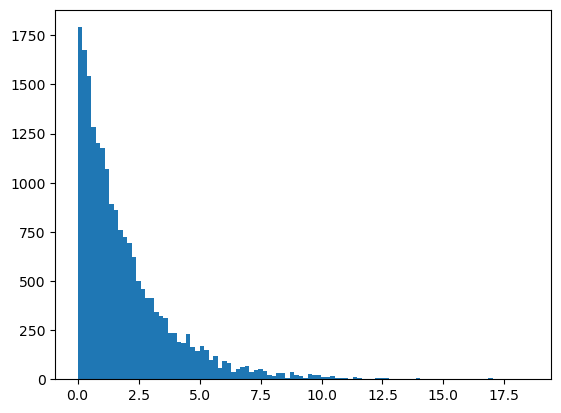

In [9]:
chi2=-2*np.load('data_4_assignment3/outputs_MCMC/logp_test_tf.npy')[0]
plt.hist(chi2,bins=100)
plt.show()